In [1]:
import numpy as np
import json
from pprint import pprint

from collections import defaultdict
import operator

import matplotlib.pyplot as plt; plt.rcdefaults()


import seaborn as sns

import sys
sys.path.append('../src')
import os
from tqdm import tqdm
from utils import rad2degree
from panoramic_camera import PanoramicCamera as camera
import cv2
import IPython

In [2]:
def imshow(img): 
  _,ret = cv2.imencode('.jpg', img) 
  i = IPython.display.Image(data=ret)
    #IPython.display.display(i)

In [3]:
data = json.load(open('../data/train.json'))

In [4]:
pprint(data[0])

{'actions': [{'act_deg_list': [[[-54.46812048841895, -29.394853246420993],
                                [160.91728306933157, 66.58795765885363],
                                [-173.4327169306684, 40.48795765885364],
                                [-129.1077169306683, 6.962957658853615],
                                [-63.85771693066823, -10.587042341146464],
                                [15.792283069331631, -19.587042341146567],
                                [85.76728306933164, -14.187042341146672],
                                [143.59228306933161, -2.712042341146572],
                                [-140.80771693066825, -3.8370423411466037],
                                [-108.40771693066822, -3.8370423411466037]],
                               [[-108.40771693066822, -3.8370423411466037]],
                               [[-108.40771693066822, -3.8370423411466037],
                                [-108.40771693066822, -3.8370423411466037],
                          

In [5]:
act_instances = {}
for instance in data:
  for action in instance['actions']:
    action['gt_latitude'] = instance['ylat_deg']
    action['gt_longitude'] = instance['xlng_deg']
    action['img_src'] = instance['img_src']
    
    act_instances[action['actionid']] = action

In [6]:
width = 4552
height = 2276
canvas = np.zeros((height,width))

pbar = tqdm(act_instances)
size = 2
min_x, min_y, max_x, max_y = width, height, 0, 0

canvases = {}
transition = {}
transitions = ['3->4', '2->3','1->2','0->1'][::-1]
transition_all = list()
for ii,t in enumerate(transitions):
  transition[t] = list()
  canvases[ii] = np.zeros((height,width))
canvases[len(transitions)] = np.zeros((height,width))

for kk,act_id in enumerate(pbar):
  
  instance = act_instances[act_id]
  for step, fovs in enumerate(instance['act_deg_list']):
    
    first_x, first_y = -1,-1
    for jj,fov in enumerate(fovs):
      center_longitude, center_latitude = fov[0], fov[1]
            
      gt_x = int(width * ((center_longitude)/360.0))
      gt_y = int(height - height * ((center_latitude + 90)/180.0))
      canvas[gt_y-size:gt_y+size,gt_x-size:gt_x+size] = 1.0

      if first_x == -1 and first_y == -1:
        first_x, first_y = gt_x, gt_y
    canvases[step][gt_y-size:gt_y+size,gt_x-size:gt_x+size] = 1.0       
    if step >= 1:
      transition['{}->{}'.format(step-1,step)].append((prev_x - first_x,prev_y - first_y))
      transition_all.append((prev_x - first_x,prev_y - first_y))
      max_x = max(max_x,(first_x - prev_x))
      max_y = max(max_y,(first_y - prev_y))
      
      min_x = min(min_x,(first_x - prev_x))
      min_y = min(min_y,(first_y - prev_y))

    prev_x, prev_y = first_x, first_y
pbar.close()

100%|██████████| 12970/12970 [00:00<00:00, 26340.28it/s]


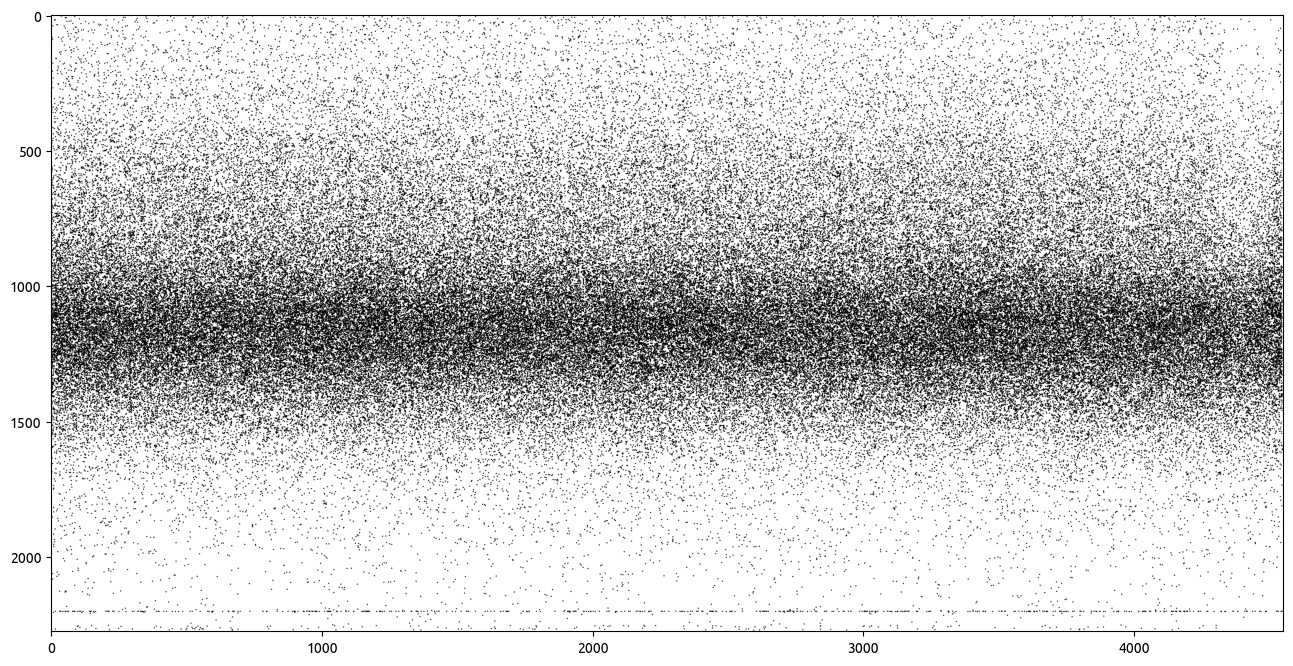

In [7]:
fig, ax = plt.subplots(figsize=(16,8))

sns.set_style("white")
sns.set_style({'font.family': 'sans-serif',
               'font.sans-serif': 'Ubuntu',
              'font_scale' : 5})

inverted = np.ones(canvas.shape) - canvas
imgplot = plt.imshow(inverted, cmap='gray')

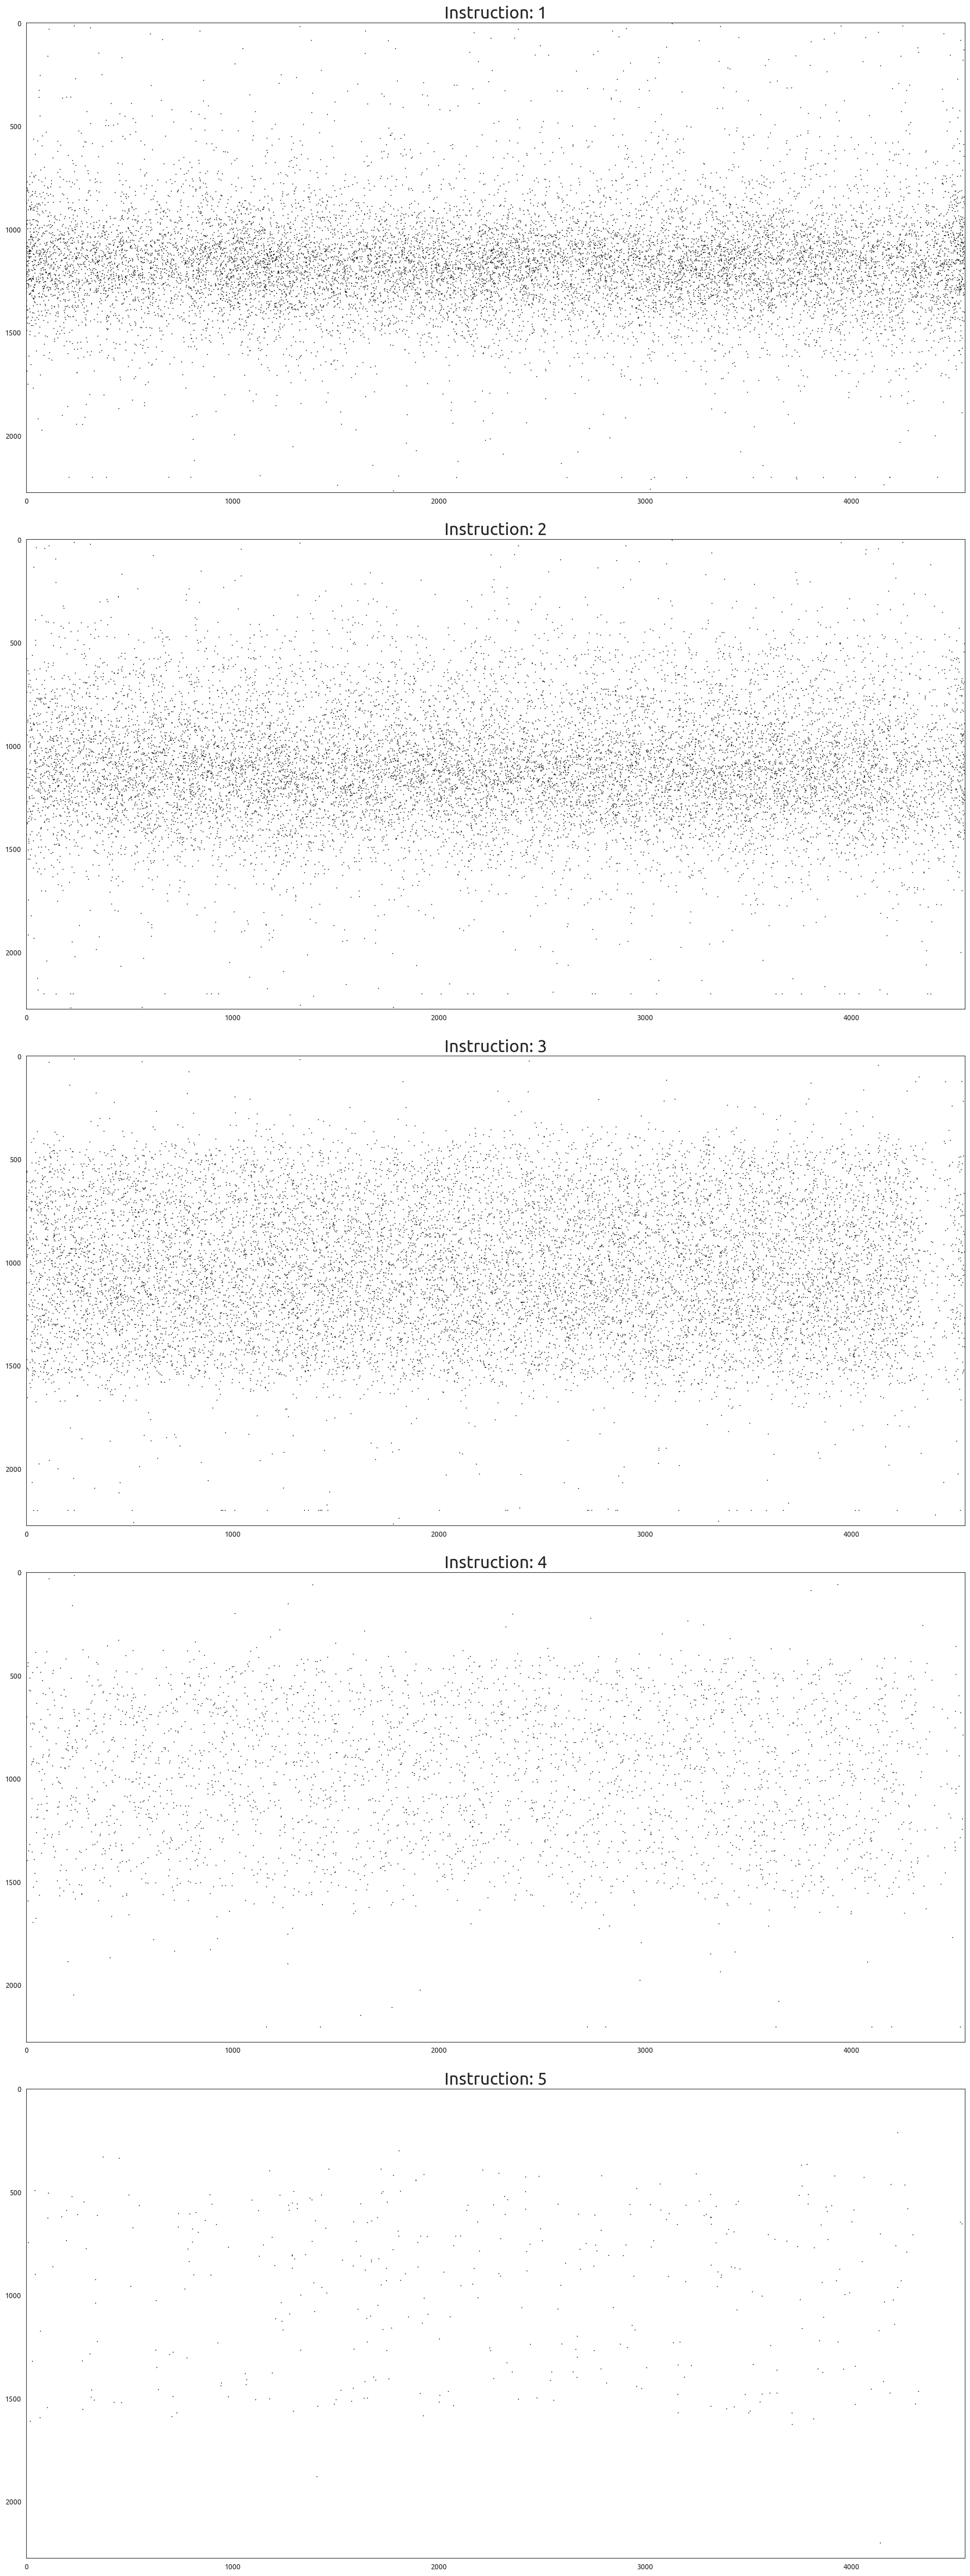

In [8]:
nrow = len(canvases)
ncols = 1

fig, axs = plt.subplots(nrows=nrow, ncols=ncols, figsize=(32,64))
fig.subplots_adjust(hspace = 0.1 ) 

FONTSIZE=24

ii = -1
for kk,c in enumerate(canvases.keys()):
  canvas = canvases[c]
  inverted = np.ones(canvas.shape) - canvas
  axs[kk].imshow(inverted, cmap='gray')
  axs[kk].set_title('Instruction: {}'.format(c+1), fontsize=FONTSIZE)
plt.rc('xtick',labelsize=FONTSIZE)
plt.rc('ytick',labelsize=FONTSIZE)
plt.show()


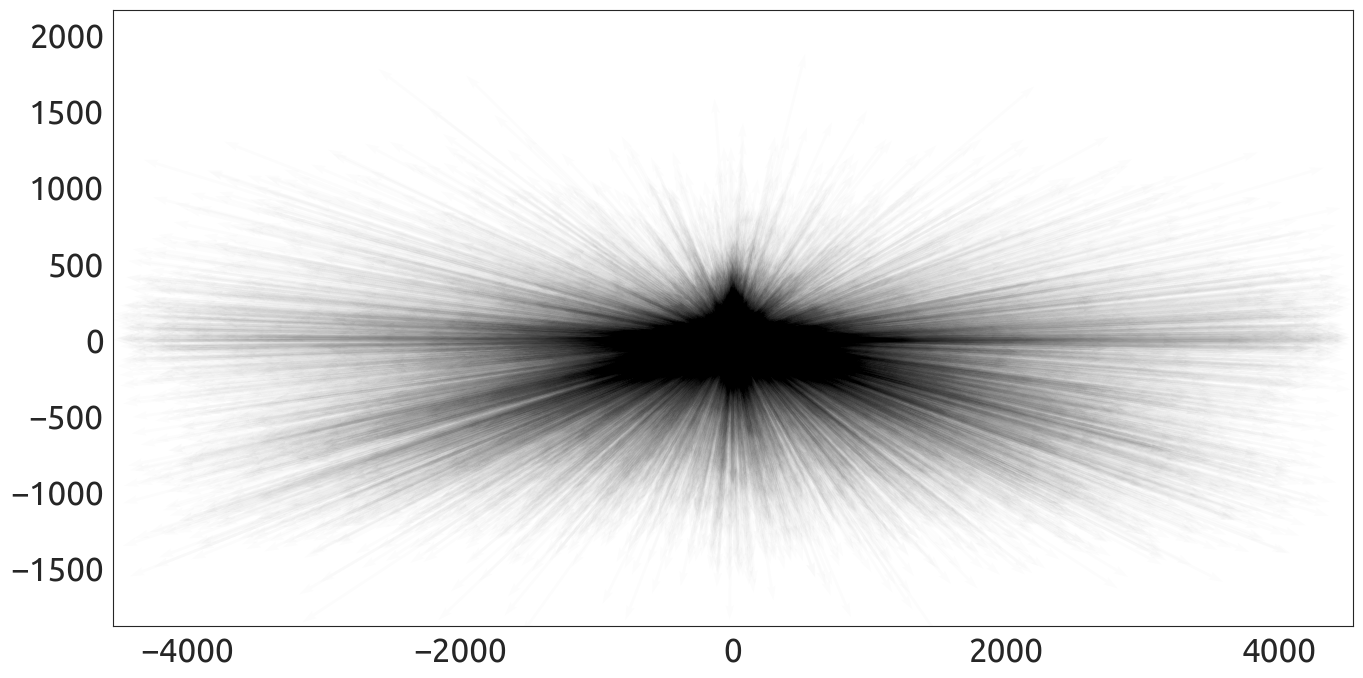

In [9]:
fig, ax = plt.subplots(figsize=(16,8))


X = []
Y = []
U = []
V = []
for t in transition_all:
  X.append(0)
  Y.append(0)
  U.append(t[0])
  V.append(t[1])

q = plt.quiver(X,Y,U,V, angles='xy', scale_units='xy', scale=1, alpha=0.01)
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)

#ax.quiverkey(q, X=0.1, Y=0.1, U=0.1,label='Quiver key, length = 10', labelpos='E')

plt.show()

0->1 12965 12965
1->2 12945 12945
2->3 3303 3303
3->4 379 379


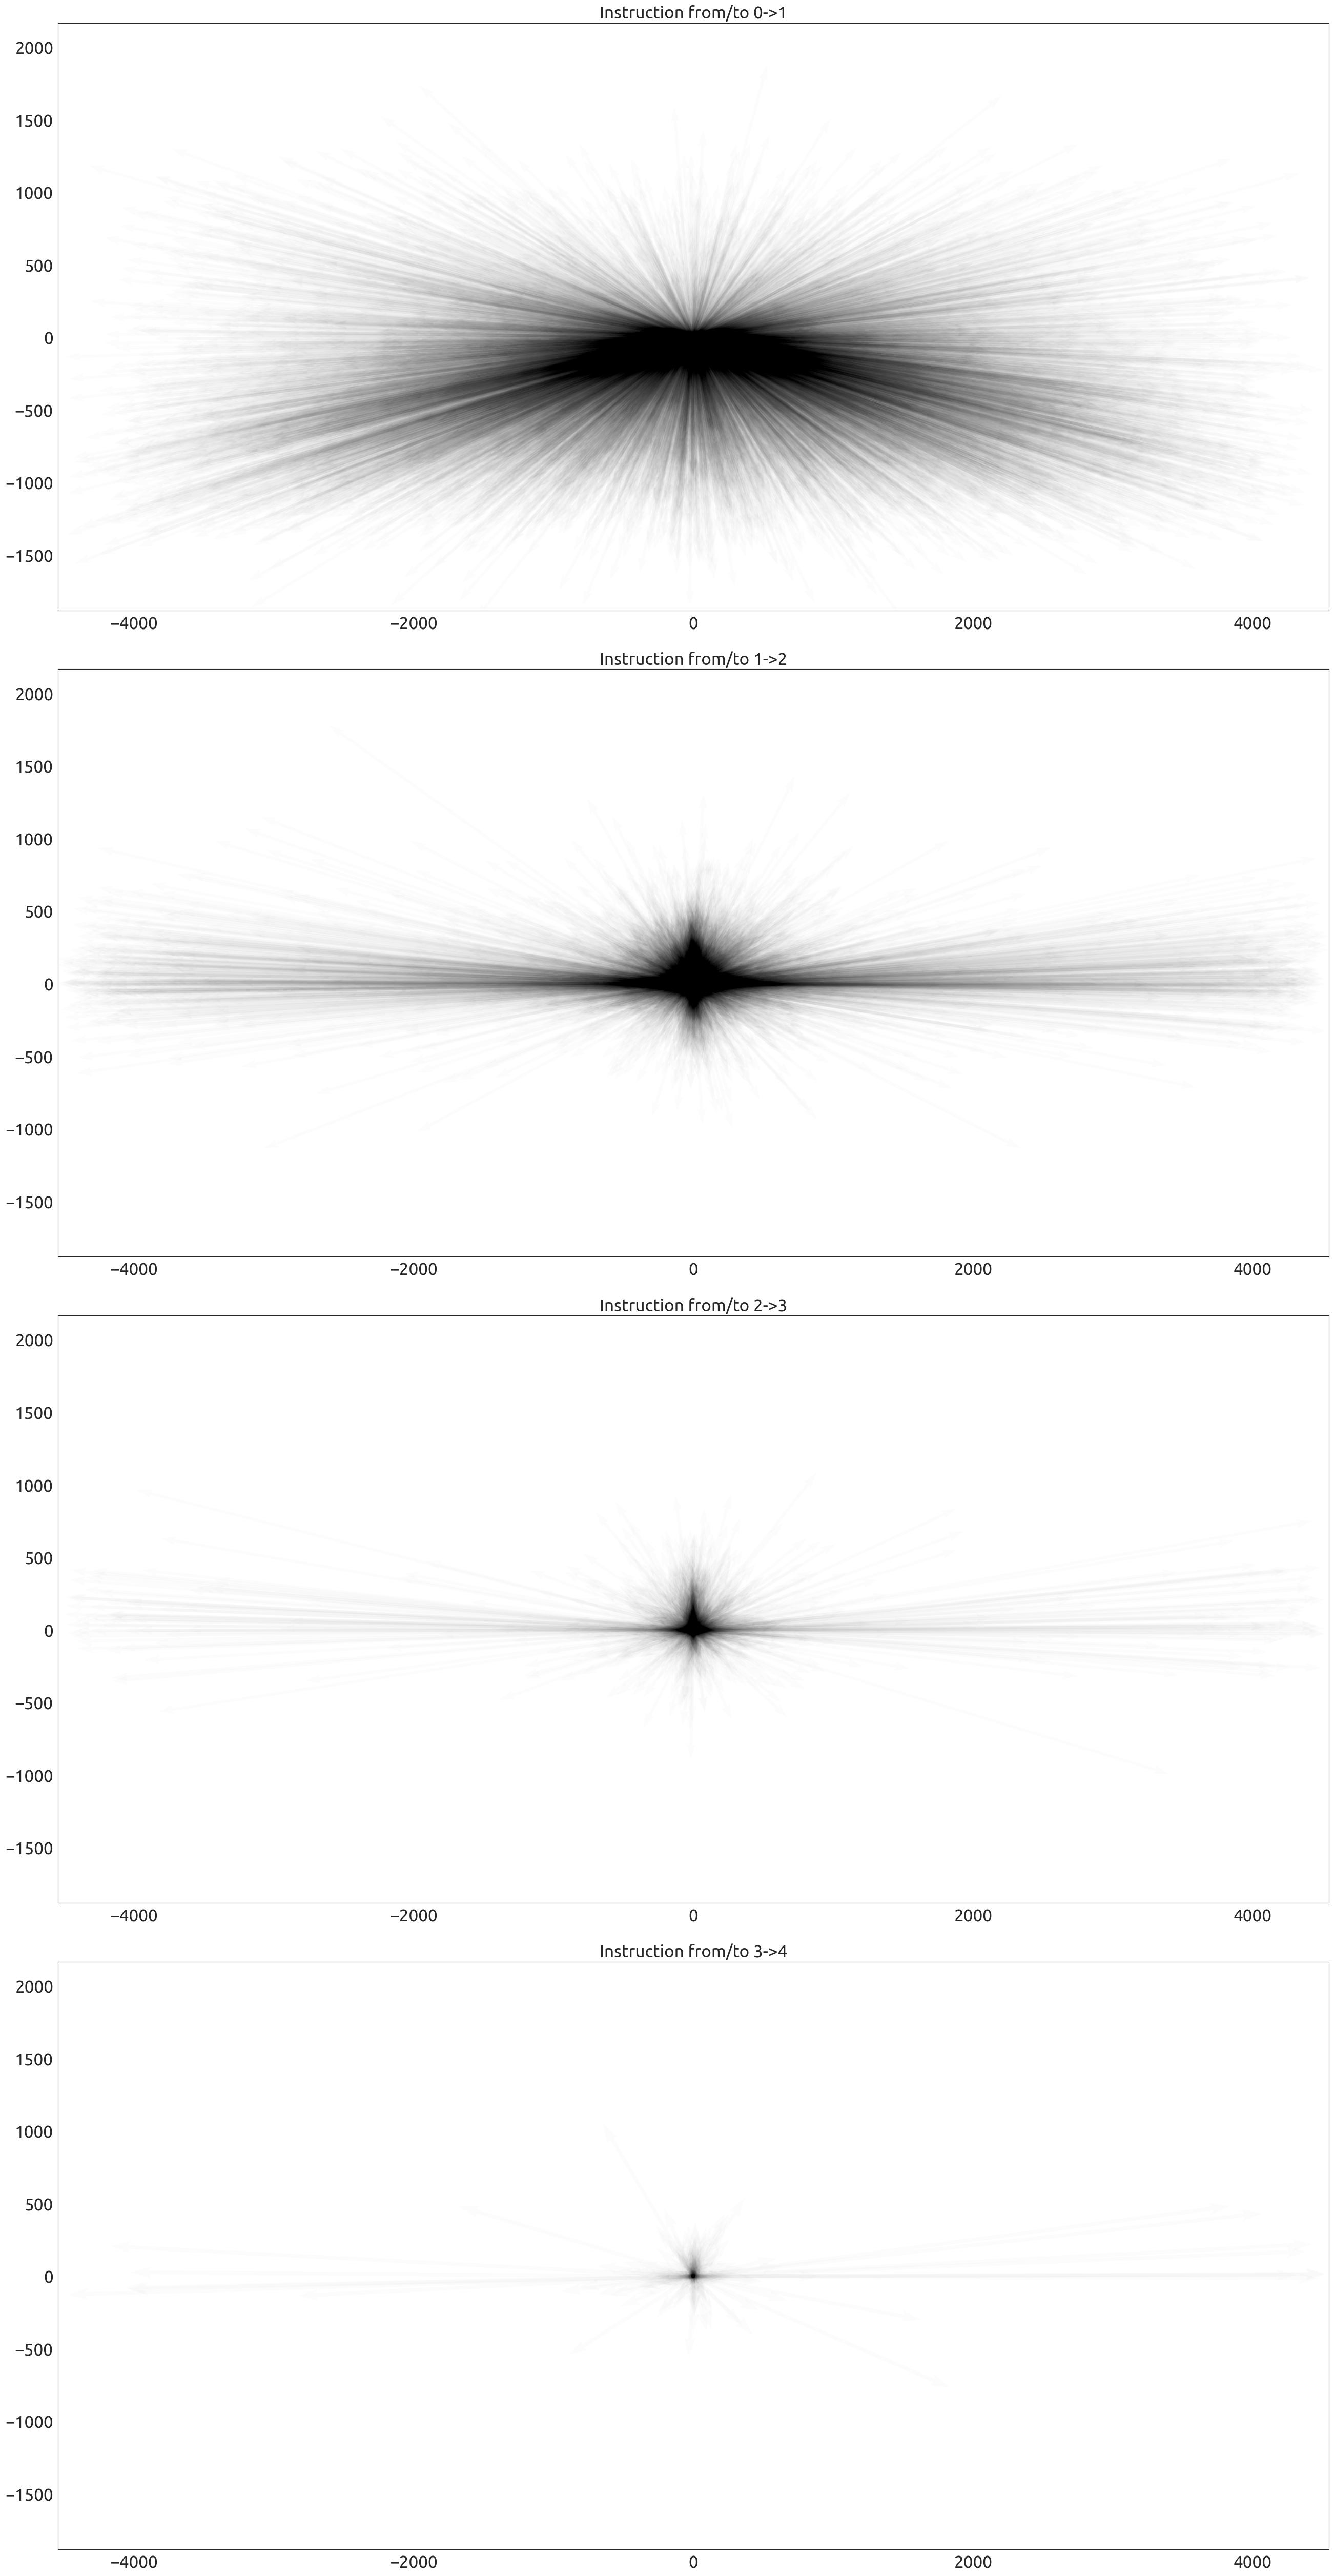

In [10]:
nrow = len(transition.keys())
ncols = 1

fig, axs = plt.subplots(nrows=nrow, ncols=ncols, figsize=(32,64))
fig.subplots_adjust(hspace = 0.1 ) 

FONTSIZE=24

ii = -1
for kk,t in enumerate(transition.keys()):
  tr = transition[t]
 
  X = []
  Y = []
  U = []
  V = []

  for tcoor in tr:
    X.append(0)
    Y.append(0)
    U.append(tcoor[0])
    V.append(tcoor[1])

  axs[kk].quiver(X,Y,U,V, angles='xy', scale_units='xy', scale=1, alpha=0.01)
  axs[kk].set_title('Instruction from/to {}'.format(t), fontsize=FONTSIZE)
  axs[kk].set_xlim(min_x, max_x)
  axs[kk].set_ylim(min_y, max_y)
  print(t,len(tr),len(X))
plt.rc('xtick',labelsize=FONTSIZE)
plt.rc('ytick',labelsize=FONTSIZE)

plt.show()